# Quantum Optimization via QAOA

_This is a final project for the IAP class 6.S089 Intro to Quantum Computing. It was a group project with Colin Poler, Consecrata Rozario and Chirag Falor._

Optimization problems pop up everywhere in business applications, and algorithms to solve them are largely responsible for the improved standard of living in the modern era. Here are a few ways that optimization has impacted your life:

- Crops are grown faster and more cheaply when resources like irrigation, fertilizer and farm equipment are applied more efficiently
- Groceries are made available more cheaply when inventory levels between grocery stores are optimized to maximize availability and minimize cost
- During the pandemic, PPE distribution to care facilities [was optimized](https://medium.com/r/?url=https%3A%2F%2Fmitsloan.mit.edu%2Fideas-made-to-matter%2Fhow-a-simple-calculator-and-job-portal-are-fighting-covid-19) to maximize the number of lives saved while minimizing logistics costs

In [1]:
import math
import numpy as np
import networkx as nx
import matplotlib as mpl
import matplotlib.pyplot as plt 
%matplotlib inline

from qiskit.aqua.components.optimizers import SPSA
from qiskit import Aer
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute
from qiskit.visualization import plot_histogram

## Our optimization problem

In this article, we're going to consider a particular optimization problem MAX-CUT, and how it can be solved with Quantum Computers. Here's an example of the MAX-CUT problem: imagine we have a (small) group of people living together in a (small) town, and they're all worried about contracting COVID-19 from their interactions:

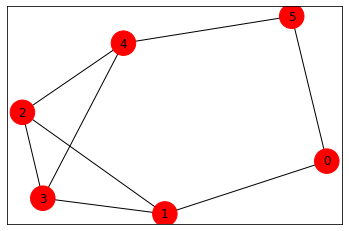

In [2]:
# Create a non-trivial graph
n = 6
V = np.arange(0,n,1)
E =[
    (0,1,1),
    (1,2,1),
    (3,2,1), # Try changing the weight of this edge to 10
    (3,4,1),
    (4,2,1),
    (1,3,1),
    (4,5,1),
    (0,5,1),
] 

G = nx.Graph()
G.add_nodes_from(V)
G.add_weighted_edges_from(E)

# Generate plot of the Graph
colors = ['r' for node in G.nodes()]
default_axes = plt.axes(frameon=True)
pos = nx.spring_layout(G)

nx.draw_networkx(G, node_color=colors, node_size=600, alpha=1, ax=default_axes, pos=pos)

<center><i>A (small) group of people that are worried about contracting COVID-19, illustrating the interactions between people. For example, the above might illustrate that people 0,1 share an office, while 1,2,3 go to the same gym and 2,3,4 go to the same grocery store.</i></center>

The above diagram might illustrate that people 0,1 share an office, while 1,2,3 go to the same gym and 2,3,4 go to the same grocery store. For whatever reason, the town council has decided upon an unusual system for reducing the spread of COVID-19: **assign each person to one of two groups, either quarantining on even days or odd days**. For instance, the town might assign person 0 to odd days and person 1 to even days, so that they won't cross paths in the office and transmit COVID-19.

Furthermore, some interactions might be more risky than others. For instance, perhaps person 4 and person 5 sit really close to each other, so it's particularly important that we separate those two people. In this case, we would assign the 4–5 edge a larger weight.

So the town now faces an optimization problem: **what is the best way to assign people to each group to minimize the remaining transmission risk?** (our fictional town won't be very social, but that's OK) Equivalently, how can we assign the people to CUT the maximum total edge weight.

Formally, we assign a variable xᵢ to each person i where xᵢ=0 is odd days and xᵢ=1 is even days. Then we note that for any particular edge, we are cutting the edge with weight wᵢⱼ if xᵢ(1-xⱼ)=1. So we want to maximize the below cost function:

$$C(x)=\sum_{i,j}^n w_{ij}x_i(1-x_j)$$

## The QAOA Algorithm

The QAOA algorithm is an approximate optimization algorithm. That means it is not guaranteed to find the best solution, but it will find a solution that is almost as good in a much more reasonable amount of time.

First, we start with n qubits which represent our variables xᵢ. For example, one possible solution would be to assign person 0 to even days, and everyone else to odd days, which we would right as |000001〉

Second, we apply a Hadamard operator to each qubit, and get a **uniform superposition of all possible solutions**. So |000001〉is just as likely as |011001〉, and more importantly they're perfectly in-phase.

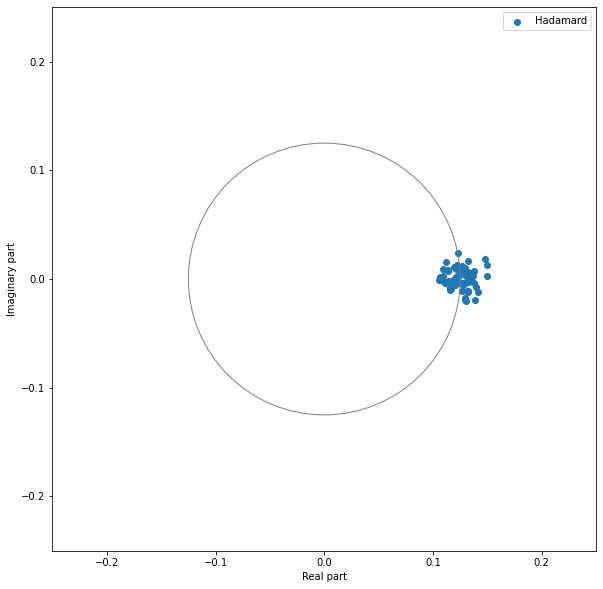

In [28]:
# Create a function to initialize the quantum circuit
def initialize_qaoa(V, E):
    qc = QuantumCircuit(len(V), len(V))
    
    qc.h(range(len(V)))
    qc.barrier()
    return qc

# Create a function that will simulate the quantum circuit by keeping track of all the states
def get_statevectors(qc):
    backend = Aer.get_backend("statevector_simulator")
    simulate = execute(qc, backend=backend)
    qc_results = simulate.result()
    return qc_results.get_statevector()

# Create a function that will plot the amplitudes of all the states
def plot_states_unitcircle(results_list, klims=2):
    # Setup the plot
    fig, ax = plt.subplots(figsize=(10,10))
    ax.set_aspect(1)
    scale = 1/np.sqrt(len(results_list[0][1]))
    ax.add_artist(plt.Circle((0,0), scale, edgecolor='gray', fill=False))
    plt.xlim([-scale*klims,scale*klims])
    plt.ylim([-scale*klims,scale*klims])
    plt.xlabel('Real part')
    plt.ylabel('Imaginary part')
    colorcycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

    prev_solutions = None
    for i, (l, solutions) in enumerate(results_list):
        color = colorcycle[i%len(colorcycle)]
        
        # Plot all the points from the state
        solutions_spreadout = solutions + np.random.normal(scale=.01, size=solutions.shape) + 1j*np.random.normal(scale=.01, size=solutions.shape)
        sc = plt.scatter(solutions_spreadout.real, solutions_spreadout.imag, c=color, label=l)

        # Add lines that connect the previous states to the current states
        if prev_solutions is not None:
            trajectories = np.vstack([prev_solutions, solutions_spreadout]).T
            trajectories = np.stack([trajectories.real, trajectories.imag], axis=2)
            lc = mpl.collections.LineCollection(trajectories, color=color)
            ax.add_collection(lc)
        prev_solutions = solutions_spreadout
    plt.legend()

qc = initialize_qaoa(V, E)
results_1 = 'Hadamard', get_statevectors(qc)
plot_states_unitcircle([results_1])

<center><i>The amplitudes of all the states after Hadamard initialization. In reality, the states are stacked on top of one another, so I spread them out randomly to visualize them. The grey circle is the "unit" circle, representing solutions that are equally likely but varying in phase. Critically, in this figure, all possible solutions have the same phase.</i></center>

Third, we apply a phase rotation that is **proportional to the cost of the solution** (with a constant of proportionality $\gamma_i$), so that the best solutions progress further than any others around the unit circle. It's kind of like a race track, where the fastest cars get around the track the fastest. First, we'll have to turn our cost function from above into a unitary operator that applies a quantum phase rotation.

$$
\begin{align*}
C(x) &= \sum_{i,j}^{n} w_{ij} x_i(1-x_j) \;\;\text{and}\;\; x_i \rightarrow \frac{1-Z_i}{2}\\
H(X) &= \sum_{i,j}^n w_{ij}\left(\frac{1-Z_i}{2}\right)\left(\frac{1+Z_j}{2}\right)\\
    &= \sum_{(i,j)\in E} w_{ij} \left(\frac{1-Z_i}{2}\right)\left(\frac{1+Z_j}{2}\right) + \left(\frac{1-Z_j}{2}\right)\left(\frac{1+Z_i}{2}\right) \\
    &= \sum_{(i,j)\in E} \frac 1 4 w_{ij} \left( 1 -Z_i +Z_j - Z_i Z_j + 1 +Z_i -Z_j - Z_i Z_j\right) \\
    &= \sum_{(i,j)\in E} \frac 1 2 w_{ij} \left( 1 - Z_i Z_j\right) \\
U_{\gamma_i} &= e^{-i \gamma_i H(X)}
\end{align*}
$$

<center><i>First we turn the classical cost function into a Hermitian (but not unitary) matrix for qubits. Then, we transform the Hermitian matrix into a unitary matrix parametrized by $\gamma_i$</i></center>

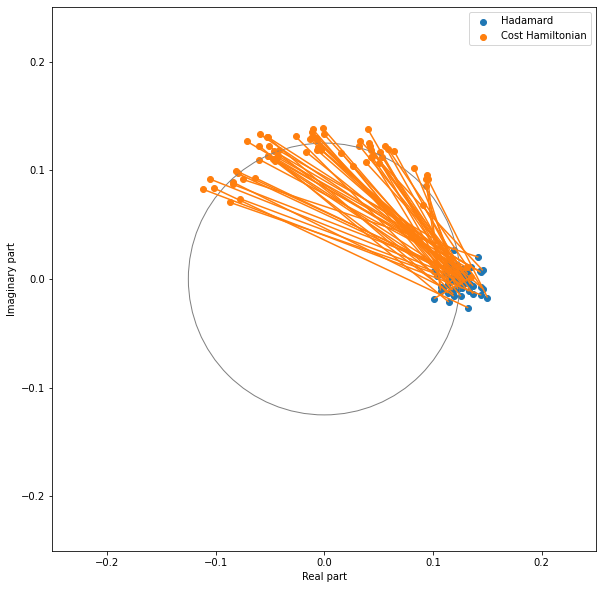

In [4]:
# Create a function that applies the above Cost Hamiltonian to the qubits
def apply_cost_hamiltonian(qc, V, E, gamma):
    for k, l, weight in E:
        qc.cp(-2*gamma*weight, k, l)
        qc.p(gamma*weight, k)
        qc.p(gamma*weight, l)
    qc.barrier()
    return qc

qc = initialize_qaoa(V, E)
qc = apply_cost_hamiltonian(qc, V, E, 0.4)
results_2 = 'Cost Hamiltonian', get_statevectors(qc)
plot_states_unitcircle([results_1, results_2])

<center><i>The amplitudes of all the solutions after the unitary cost transform (again, the spread is for visualization only). Most importantly, the best solutions have progressed the furthest around the "track", and are now on the left of the diagram. (note: although tempting to just grab those solutions now, remember that these are quantum phases that cannot be measured just yet)</i></center>

Fourth, we apply a **mixing between similar solutions to move out the best solutions and make them more likely to be measured at the end**. In spirit, we would like to compare similar solutions (|100001〉is similar to|101001〉because only one bit changed). The solutions that are better than all their peers (and have progressed further around the track) should move further out, while the solutions that are worse than all their peers should move further in and the solutions in-between shouldn't go much one way or the other.

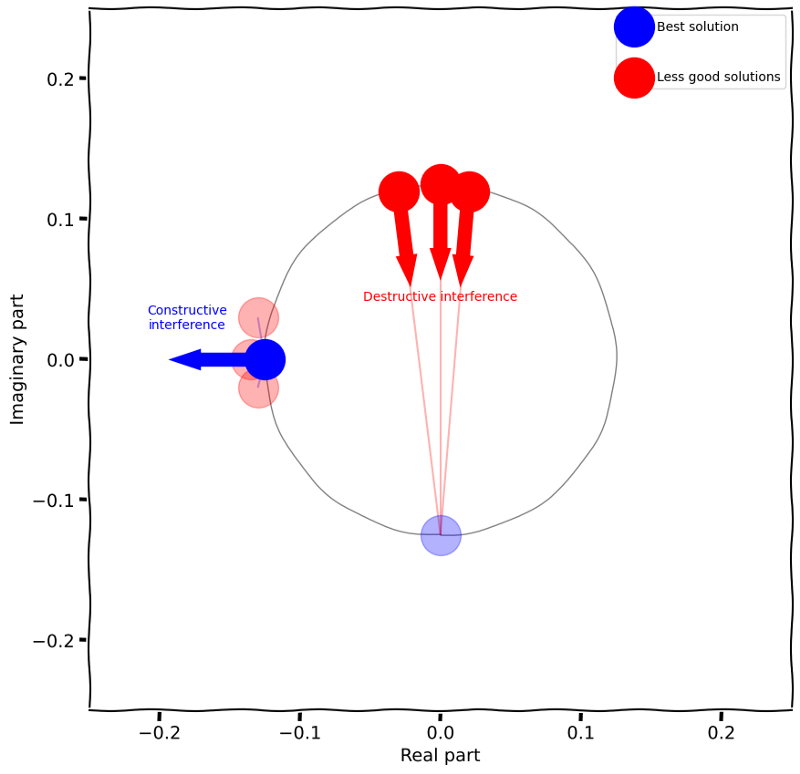

<center><i>(conceptual illustration) Applying mixing to move the best solutions outwards, while moving the less-good solutions inwards. By projecting nearby solutions around by 90° and doing linear combinations, we can in principle use constructive interference to move the better solutions outwards and destructive interference to move worse solutions inwards. But clearly, this is going to depend on everything lining up just perfectly…</i></center>

In practice, with the mathematical tools we have available, what we actually do is project the most similar solutions (only one bit changed e.g. |100001〉and |101001〉) an extra 90° around the track, and then perform a linear combination of strength $\beta_i$ to mix each real solution with projections of similar solutions. If everything lines up perfectly, the **best solutions move outwards and the worst ones move inwards**.

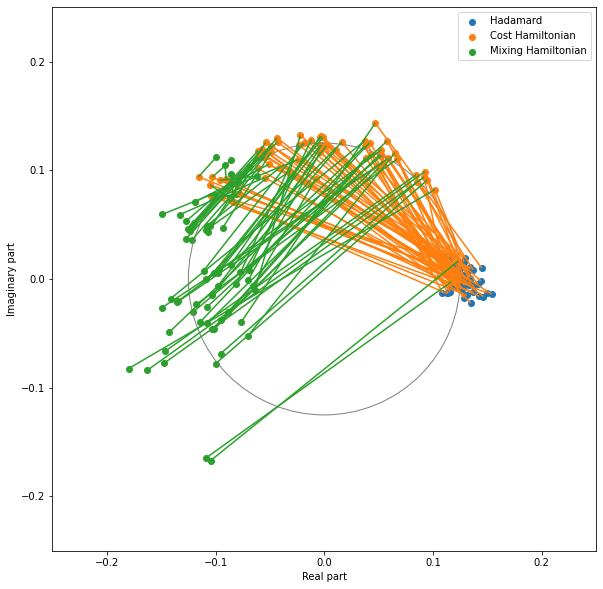

In [5]:
# Create a function that applies the above Mixing Hamiltonian to the qubits
def apply_mixing_hamiltonian(qc, V, E, beta):
    qc.rx(2*beta, range(len(V)))
    qc.barrier()
    return qc

qc = initialize_qaoa(V, E)
qc = apply_cost_hamiltonian(qc, V, E, 0.4)
qc = apply_mixing_hamiltonian(qc, V, E, 0.8)
results_3 = 'Mixing Hamiltonian', get_statevectors(qc)
plot_states_unitcircle([results_1, results_2, results_3])

<center><i>(actual results) After applying the mixing Hamiltonian, indeed some solutions have moved outwards and others have moved inwards. But unfortunately things DIDN'T line up, and the best solutions went nowhere, while the WORST solutions got more likely.</i></center>

Fifth, we can repeat the above two steps of cost and mixing a total of $p$ times, using new values of $\gamma_i$ and $\beta_i$. If we perform more iterations, we can get those best solutions to move further and further out. But for simplicity, this example uses $p=1$.

Finally, we measure the state of the qubits. The probability of measuring a state is proportional to the square of the radius above. So the most likely states to measure are the ones that are furthest out, which are evidently the ones which put all people in the same group and made zero cuts. So our optimization didn't do so great…

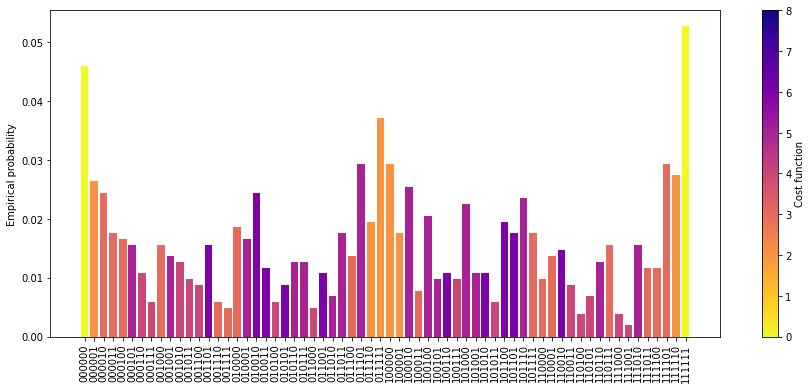

In [20]:
# Create a function that terminates the circuit by measuring the qubits and collapsing the state
def terminate_qaoa(qc, V, E):
    qc.measure(range(len(V)),range(len(V)))
    return qc

# Simulate the circuit digitally
def get_simulated_results(qc, shots=1024):
    backend = Aer.get_backend("qasm_simulator")
    simulate = execute(qc, backend=backend, shots=shots)
    qc_results = simulate.result()
    counts = qc_results.get_counts()
    counts = sorted([(k,v) for k, v in counts.items()], key=lambda x: x[0])
    return counts

# Compute the cost of a given solution
def compute_cost_function(x, V, E):
    if isinstance(x, str):
        x = [c == '1' for c in x]
    assert len(x) == len(V)
    return sum(
        weight*x[k]*(1-x[l]) + weight*x[l]*(1-x[k])
        for k, l, weight
        in E
    )

# Create a function to make a plot of how often each solution occurs
# Also coloring each solution by the cost of the solution
def plot_states(counts, V, E):
    fig = plt.figure(figsize=(15,6))
    ax = fig.add_subplot(1,1,1)
    ax.tick_params(axis='x', labelrotation=90)
    ax.set_ylabel('Empirical probability')
    cmap = mpl.cm.get_cmap('plasma_r')
    def cost_to_color(cost, V, E):
        return cmap(cost/len(E))
    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=len(E)), cmap=cmap))
    cbar.ax.set_ylabel('Cost function')
    
    # Plot the normalized counts on the bar chart
    norm = sum(v for k,v in counts)
    ax.bar(
        x=[k for k,v in counts],
        height=[v/norm for k,v in counts],
        color=[cost_to_color(compute_cost_function(k, V, E), V, E) for k,v in counts]
    )

qc = initialize_qaoa(V, E)
qc = apply_cost_hamiltonian(qc, V, E, 0.4)
qc = apply_mixing_hamiltonian(qc, V, E, 0.8)
qc = terminate_qaoa(qc, V, E)
counts = get_simulated_results(qc)
plot_states(counts, V, E)

<center><i>The algorithm prefers to select the solutions which make ZERO cuts, because we didn't get lucky. The expected value of the cost function is about 3.7.</i></center>

But in any case, we made a procedure that ran the above algorithm for particular values of $\gamma_i$ and $\beta_i$ and returned the average (expectation) cost function for 1024 runs of the quantum computer.

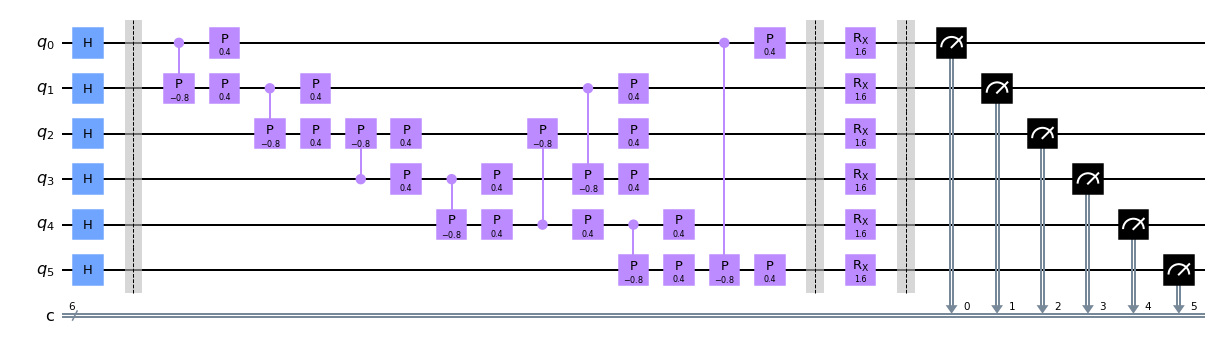

In [7]:
# Create a function that constructs the full QAOA circuit
def construct_full_qaoa(p, gammas, betas, V, E):
    qc = initialize_qaoa(V, E)
    for i in range(p):
        qc = apply_cost_hamiltonian(qc, V, E, gammas[i])
        qc = apply_mixing_hamiltonian(qc, V, E, betas[i])
    qc = terminate_qaoa(qc, V, E)
    return qc

# Create a function that simulates the full QAOA
def get_expected_cost(qc, V, E):
    counts = get_simulated_results(qc)
    probabilities = np.array([v for k,v in counts]) / sum(v for k,v in counts)
    costs = np.array([compute_cost_function(k, V, E) for k,v in counts])
    return np.sum(probabilities * costs)

qc = construct_full_qaoa(1, [.4], [.8], V, E)
# Draw a quantum circuit diagram for the QAOA
qc.draw('mpl')

In [8]:
print("The expected value of the cost function is {:.2f}".format(
    get_expected_cost(qc, V, E)
))

The expected value of the cost function is 3.63


## The plot twist

To actually get a good optimization, we need to find values of γᵢ and βᵢ that maximize the average (expectation) cost function. So, we used a variant of gradient-descent similar to what machine learning does (in this case, the variant was SPSA, which does a good job dealing with the inherent randomness of the evaluations).

In [37]:
# Use numeric optimization to find the best values of gamma and beta
def optimize_gammas_betas(p, start=None):
    def objective_function(point):
        return -get_expected_cost( # flip to maximize instead of minimize
            construct_full_qaoa(p, point[:p], point[p:], V, E),
            V, E
        )
    
    optimizer = SPSA(
        maxiter=500*p, # Need more iterations to converge when p is large
        c0=0.1, # Our full range is [0,pi] so choose a small c0
        c1=0.1, # Our full range is [0,pi] so choose a small c1
    )
    if start is None:
        start = [math.pi/2]*p+[math.pi/4]*p
    point, value, nfev = optimizer.optimize(
        num_vars=2*p,
        objective_function=objective_function,
        initial_point=start
    )
    return point[:p], point[p:]

gammas, betas = optimize_gammas_betas(1)
gammas, betas

(array([0.603689]), array([1.22155688]))

So with 500 iterations of the quantum computer, we ultimately found that for p=1, the best solution is $\gamma_0=0.60$ and $\beta_0=1.22$ (you may get different numbers because it is ultimately stochastic). And it works well!

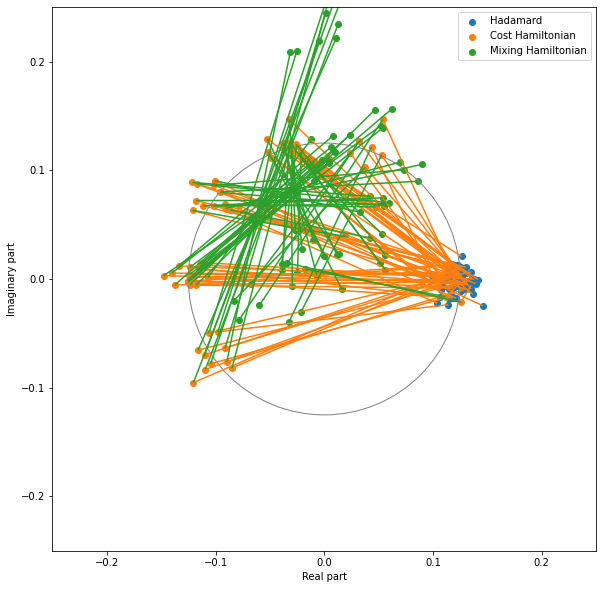

In [22]:
# Based on my results, if you don't want to wait for the above
# gammas = [0.60]
# betas =  [1.22]

qc = initialize_qaoa(V, E)
results_1 = 'Hadamard', get_statevectors(qc)
qc = apply_cost_hamiltonian(qc, V, E, 0.62)
results_2 = 'Cost Hamiltonian', get_statevectors(qc)
qc = apply_mixing_hamiltonian(qc, V, E, 1.23)
results_3 = 'Mixing Hamiltonian', get_statevectors(qc)
plot_states_unitcircle([results_1, results_2, results_3])

<center><i>With the right values, it is clear that the best solutions (bottom left in orange) did in fact move outwards, while the worst solutions (top right in orange) moved inwards.</i></center>

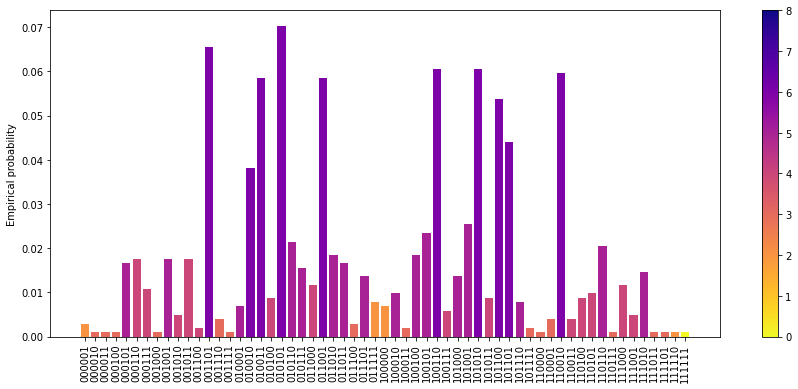

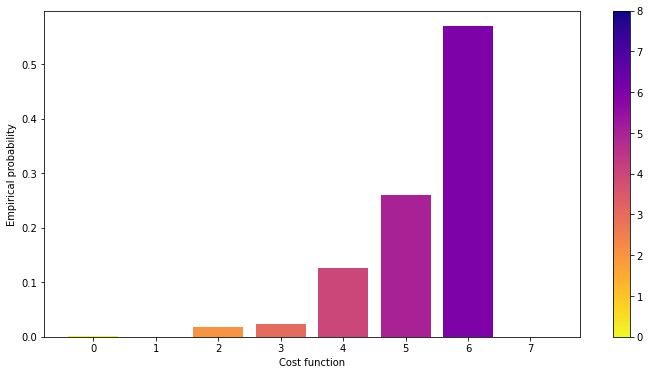

In [12]:
def plot_costs(counts, V, E):
    fig = plt.figure(figsize=(12,6))
    ax = fig.add_subplot(1,1,1)
    ax.set_ylabel('Empirical probability')
    ax.set_xlabel('Cost function')
    cmap = mpl.cm.get_cmap('plasma_r')
    def cost_to_color(cost, V, E):
        return cmap(cost/len(E))
    fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=len(E)), cmap=cmap))
    
    # Plot the normalized probabilities of costs
    norm = sum(v for k,v in counts)
    cost_counts = {i: 0 for i in range(len(E))}
    for k, v in counts:
        cost = compute_cost_function(k, V, E)
        cost_counts[cost] += v / norm
    
    cost_counts = sorted([(k,v) for k, v in cost_counts.items()], key=lambda x: x[0])
    ax.bar(
        x=[k for k,v in cost_counts],
        height=[v for k,v in cost_counts],
        color=[cost_to_color(k, V, E) for k,v in cost_counts]
    )

qc = construct_full_qaoa(1, gammas, betas, V, E)
counts = get_simulated_results(qc)
plot_states(counts, V, E)
plot_costs(counts, V, E)

<center><i>Distribution of cost functions as output from the above. Indeed, the best possible solution is 6, which happens quite frequently!</i></center>

Furthermore, because our architecture is quite general, we can actually perform exactly the same analysis for any $p$. For example, with $p=4$, we get the following:

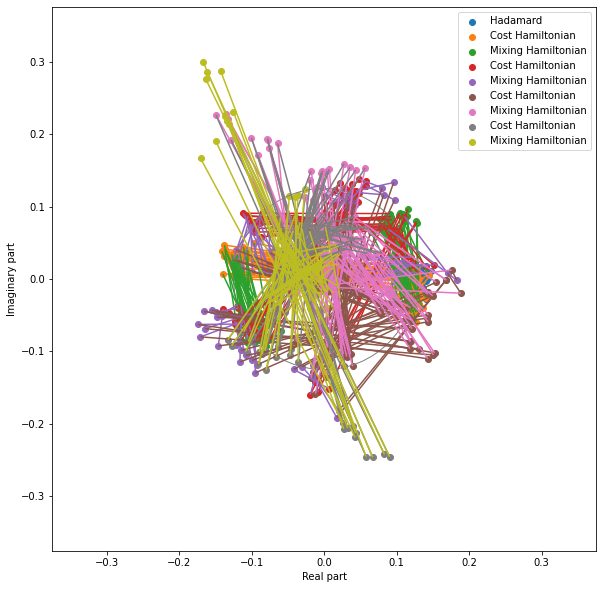

In [38]:
gammas, betas = optimize_gammas_betas(4, start=[3.04,  1.44, 1.34, 0.46, 0.84, -0.14, 0.70, 1.22])

results = []
qc = initialize_qaoa(V, E)
results.append(('Hadamard', get_statevectors(qc)))
for i in range(len(gammas)):
    qc = apply_cost_hamiltonian(qc, V, E, gammas[i])
    results.append(('Cost Hamiltonian', get_statevectors(qc)))
    qc = apply_mixing_hamiltonian(qc, V, E, betas[i])
    results.append(('Mixing Hamiltonian', get_statevectors(qc)))
plot_states_unitcircle(results, klims=3)

<center><i>The phase plot with p=4 is super messy. But the important thing is that the good solutions move way out to the top left.</i></center>

Now having the optimal values of gamma and beta, we can see how well QAOA does:

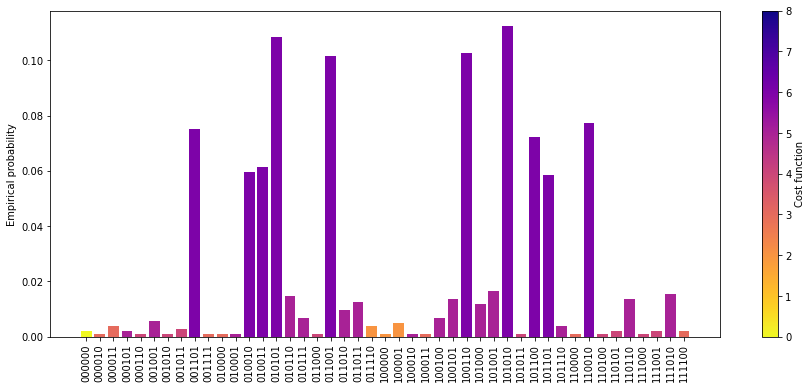

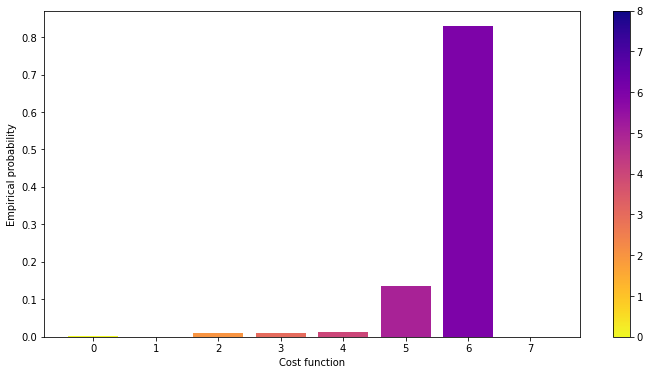

In [42]:
# Based on my results, if you don't want to wait for the above
# gammas = [3.09,  2.00, 0.72, 0.48]
# betas =  [0.46, -0.16, 0.66, 1.36]

qc = construct_full_qaoa(4, gammas, betas, V, E)
counts = get_simulated_results(qc)
plot_states(counts, V, E)
plot_costs(counts, V, E)

<center><i>The cost histogram of the solution with p=4. Clearly, the algorithm has gotten MUCH better at identifying the best solution with C(x)=6</i></center>

## The solution

In the end, the most likely solution returned was |011001〉, meaning person 1,2 and person 5 go out on even days. And you can verify for yourself with the graph at the top that you can't do any better.